# Description:
- Train a CNN Model
- Evaluate it
- Re-train the CNN model with a GA optimising the number of layers and the layer size
- Evaluate the CNN w/ GA
- Compare

## Imports & Data Preparation

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
    array_to_img,
)
import os
from PIL import Image
import cv2

In [101]:
np.random.seed(0)

In [102]:
import os
import shutil

# Source and destination directories
src_dir = "./att_faces_orig"
dst_dir = "./att_faces"

# Check if the destination directory doesn't exist
if not os.path.exists(dst_dir):
    # Copy the directory and its contents
    shutil.copytree(src_dir, dst_dir)

In [103]:
datadir = "./att_faces/Training"

In [104]:
os.listdir(datadir)

['s37',
 's40',
 's31',
 's21',
 's19',
 's2',
 's25',
 's11',
 's32',
 's26',
 's12',
 's29',
 's28',
 's16',
 's17',
 's1',
 's38',
 's5',
 's27',
 's8',
 's6',
 's24',
 's33',
 's18',
 's4',
 's36',
 's35',
 's10',
 's22',
 's39',
 's14',
 's34',
 's3',
 's9',
 's23',
 's15',
 's20',
 's13',
 's30',
 's7']

In [105]:
len(os.listdir(datadir))

40

In [106]:
def convert_images(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file

            if filepath.endswith(".pgm"):
                img = Image.open(filepath)
                png_filepath = os.path.splitext(filepath)[0] + ".png"
                img.save(png_filepath)
                os.remove(filepath)
            if "Zone" in filepath:
                os.remove(filepath)


convert_images(datadir)

In [107]:
len(os.listdir(datadir))

40

In [108]:
ex = datadir + "/s1/1.png"

In [109]:
img = load_img(ex)

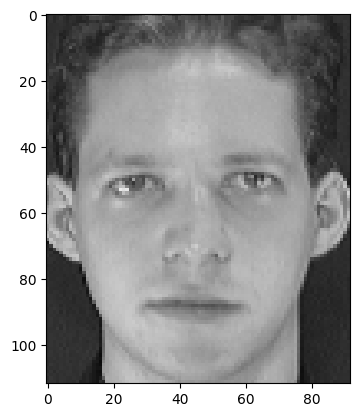

In [110]:
plt.imshow(img)

Here we can see that the dimensions of the images are 112, 93

In [111]:
arr = img_to_array(img)
arr.shape

(112, 92, 3)

In [112]:
arr.min()

11.0

In the below cell, we are performing the following:
1. Rescaling the images' pixel values from 0,255 to 0,1 (normalisation)
2. Take batches of 25 images from datadir
3. Convert the images to grayscale
4. Convert labels to categorical
5. Setting the target output size for all images to 112, 92

In [113]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

data_set = datagen.flow_from_directory(
    datadir,
    batch_size=25,
    color_mode="grayscale",
    target_size=(112, 92),
    class_mode="categorical",
    seed=42,
)

Found 360 images belonging to 40 classes.


In [114]:
data_set.class_indices

{'s1': 0,
 's10': 1,
 's11': 2,
 's12': 3,
 's13': 4,
 's14': 5,
 's15': 6,
 's16': 7,
 's17': 8,
 's18': 9,
 's19': 10,
 's2': 11,
 's20': 12,
 's21': 13,
 's22': 14,
 's23': 15,
 's24': 16,
 's25': 17,
 's26': 18,
 's27': 19,
 's28': 20,
 's29': 21,
 's3': 22,
 's30': 23,
 's31': 24,
 's32': 25,
 's33': 26,
 's34': 27,
 's35': 28,
 's36': 29,
 's37': 30,
 's38': 31,
 's39': 32,
 's4': 33,
 's40': 34,
 's5': 35,
 's6': 36,
 's7': 37,
 's8': 38,
 's9': 39}

Storing the image paths and corresponding classes for each image.

Each image

In [115]:
images_dir = []
class_out = []
i = 0
for folder in os.listdir(datadir):
    if folder != "README":
        for filename in os.listdir(datadir + "/" + folder):
            images_dir.append(datadir + "/" + folder + "/" + filename)
            out = int(i / 9) + 1
            class_out.append(out)
            i += 1

In [116]:
df = pd.DataFrame({"image_dir": images_dir, "class": class_out})

In the below cell, we can see that there are 36 image classes available in the dataset post-cleaning

In [117]:
display(df)

,image_dir,class
0,./att_faces/Training/s37/3.png,1
1,./att_faces/Training/s37/2.png,1
2,./att_faces/Training/s37/9.png,1
3,./att_faces/Training/s37/4.png,1
4,./att_faces/Training/s37/1.png,1
...,...,...
355,./att_faces/Training/s7/1.png,40
356,./att_faces/Training/s7/5.png,40
357,./att_faces/Training/s7/6.png,40
358,./att_faces/Training/s7/8.png,40


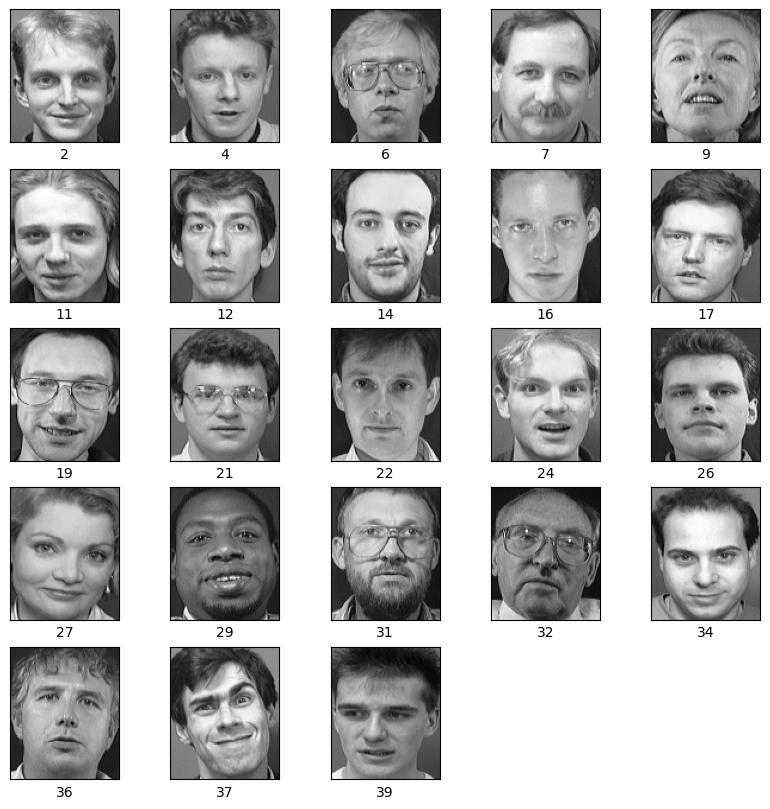

In [118]:
plt.figure(figsize=(10, 10))
for i in range(1, 24):
    img = load_img(df["image_dir"][i * 15], color_mode="grayscale")
    plt.subplot(5, 5, i, xticks=[], yticks=[])
    plt.imshow(img, cmap="gray")
    plt.xlabel(df["class"][i * 15])
plt.savefig("sample_face.png", bbox_inches="tight")
plt.show()

In [119]:
images = []
for filepath in df["image_dir"]:
    images.append(cv2.imread(filepath, 0))
images = np.array(images)

In [120]:
images.shape

(360, 112, 92)

In [121]:
images = images / 255.0

In [122]:
classes = df.iloc[:, 1].values

In [123]:
classes = classes[:, np.newaxis]
classes[:20]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3]])

## Standard CNN Model

In [124]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [125]:
tensorflow.config.list_physical_devices("GPU")

[]

Building a sequential CNN model

In [126]:
model = Sequential()
# Input layer with the same size as
model.add(
    Conv2D(
        74,
        kernel_size=(9, 9),
        padding="same",
        activation="relu",
        input_shape=(112, 92, 1),
    )
)
# Pooling layer with a filter size of 2x2, stride = 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Convolutional layer with 27 filters, each with a 3x3 kernel size
model.add(Conv2D(27, kernel_size=(3, 3), padding="same", activation="relu"))
# Pooling layer with a filter size of 2x2, stride = 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Convolutional layer with 23 filters, each with a 2x2 kernel size
model.add(Conv2D(23, kernel_size=(2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Flatten layer to convert the 2D feature maps into a 1D feature vector
model.add(Flatten())
# Dropout layer: randomly drop out nodes in layers to prevent overfitting
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu"))
model.add(Dense(40, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/home/adityamaanas/Genetic-CNN/.env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [127]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 112, 92, 74)    │         6,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 46, 74)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 46, 27)     │        18,009 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 23, 27)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 23, 23)     │         2,507 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 11, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3542)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3542)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,814,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,861,120 (7.10 MB)

 Trainable params: 1,861,120 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
X_train, X_test, Y_train, Y_test = train_test_split(
    images, classes, test_size=0.3, stratify=classes, random_state=42
)

In [129]:
X_train.shape

(252, 112, 92)

In [130]:
Y_test.shape

(108, 1)

In [131]:
Y_train.shape

(252, 1)

In [132]:
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

In [133]:
X_train.shape

(252, 112, 92, 1)

In [134]:
checkpointer = ModelCheckpoint(
    filepath="model_weights.keras", save_best_only=True, verbose=1
)

Fitting/training the model with the data from the test train split:

In [135]:
from keras.utils import to_categorical

Y_train_adjusted = Y_train - 1  # adjust labels to start from 0
Y_train_one_hot = to_categorical(Y_train_adjusted, num_classes=40)
history = model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=10)

Epoch 1/10


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.0186 - loss: 3.7046
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.0393 - loss: 3.6826
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.0319 - loss: 3.6612
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.0441 - loss: 3.6274
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.0750 - loss: 3.4450
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.2614 - loss: 2.9681
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.2823 - loss: 2.6037
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5318 - loss: 1.8403
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.6134 - loss: 1.2566
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8173 - loss: 0.8478


Accuracy over each training epoch:

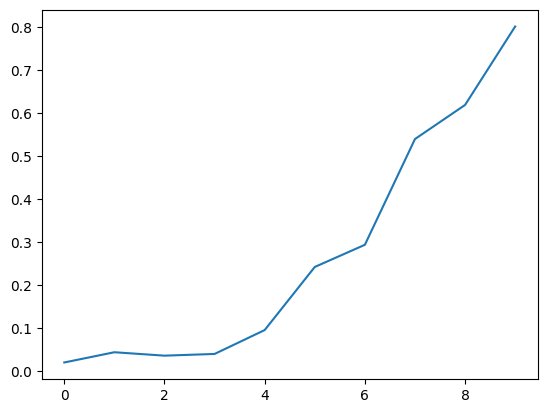

In [136]:
plt.plot(history.history["accuracy"])

Evaluating the model: What's the final accuracy on the test data?

In [137]:
Y_test_adjusted = Y_test - 1  # adjust labels to start from 0
Y_test_one_hot = to_categorical(Y_test_adjusted, num_classes=40)
model.evaluate(X_test, Y_test_one_hot)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8313 - loss: 0.6183


[0.5869453549385071, 0.8333333134651184]

In [138]:
train_acc = history.history["accuracy"]
best = max(train_acc)

In [139]:
best * 100

80.15872836112976

Summary:
- Total params: 1,861,120 (7.10 MB)
- Trainable params: 1,861,120 (7.10 MB)
- Non-trainable params: 0 (0.00 B)
- 252 training samples
- 108 testing samples
- 83% testing accuracy

## CNN Optimised by a Genetic Algorithm

Adding extra dimensions for missing colour channels that are expected by CNN (grayscale images)

In [140]:
images = images[:, :, :, np.newaxis]

In [141]:
images[0].shape

(112, 92, 1)

In [142]:
class CNN(Sequential):
    def __init__(self, nfilters, sfilters):
        super().__init__()
        tensorflow.random.set_seed(0)
        self.add(
            Conv2D(
                nfilters[0],
                kernel_size=(sfilters[0], sfilters[0]),
                padding="same",
                activation="relu",
                input_shape=(112, 92, 1),
            )
        )
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.add(
            Conv2D(
                nfilters[1],
                kernel_size=(sfilters[1], sfilters[1]),
                padding="same",
                activation="relu",
            )
        )
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.add(
            Conv2D(
                nfilters[2],
                kernel_size=(sfilters[2], sfilters[2]),
                padding="same",
                activation="relu",
            )
        )
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.add(Flatten())
        self.add(Dropout(0.3))
        self.add(Dense(512, activation="relu"))
        self.add(Dense(40, activation="softmax"))
        self.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

In [143]:
class Genetic:

    def __init__(self, pop_size, nlayers, max_nfilters, max_sfilters):
        self.pop_size = pop_size
        self.nlayers = nlayers
        self.max_nfilters = max_nfilters
        self.max_sfilters = max_sfilters
        self.max_acc = 0
        self.best_arch = np.zeros((1, 6))
        self.gen_acc = []

    def generate_population(self):
        np.random.seed(0)
        pop_nlayers = np.random.randint(
            1, self.max_nfilters, (self.pop_size, self.nlayers)
        )
        pop_sfilters = np.random.randint(
            1, self.max_sfilters, (self.pop_size, self.nlayers)
        )
        pop_total = np.concatenate((pop_nlayers, pop_sfilters), axis=1)
        return pop_total

    def select_parents(self, pop, nparents, fitness):
        parents = np.zeros((nparents, pop.shape[1]))
        for i in range(nparents):
            best = np.argmax(fitness)
            parents[i] = pop[best]
            fitness[best] = -99999
        return parents

    def crossover(self, parents):
        nchild = self.pop_size - parents.shape[0]
        nparents = parents.shape[0]
        child = np.zeros((nchild, parents.shape[1]))
        for i in range(nchild):
            first = i % nparents
            second = (i + 1) % nparents
            child[i, :2] = parents[first][:2]
            child[i, 2] = parents[second][2]
            child[i, 3:5] = parents[first][3:5]
            child[i, 5] = parents[second][5]
        return child

    def mutation(self, child):
        for i in range(child.shape[0]):
            val = np.random.randint(1, 6)
            ind = np.random.randint(1, 4) - 1
            if child[i][ind] + val > 100:
                child[i][ind] -= val
            else:
                child[i][ind] += val
            val = np.random.randint(1, 4)
            ind = np.random.randint(4, 7) - 1
            if child[i][ind] + val > 20:
                child[i][ind] -= val
            else:
                child[i][ind] += val
        return child

    def fitness(self, pop, X, Y, epochs):
        pop_acc = []
        for i in range(pop.shape[0]):
            nfilters = pop[i][0:3]
            sfilters = pop[i][3:]
            model = CNN(nfilters, sfilters)
            H = model.fit(X, Y, batch_size=32, epochs=epochs)
            acc = H.history["accuracy"]
            pop_acc.append(max(acc) * 100)
        if max(pop_acc) > self.max_acc:
            self.max_acc = max(pop_acc)
            self.best_arch = pop[np.argmax(pop_acc)]
        self.gen_acc.append(max(pop_acc))
        return pop_acc

    def smooth_curve(self, factor, gen):
        smoothed_points = []
        for point in self.gen_acc:
            if smoothed_points:
                prev = smoothed_points[-1]
                smoothed_points.append(prev * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        plt.plot(range(gen + 1), smoothed_points, "g", label="Smoothed training acc")
        plt.xticks(np.arange(gen + 1))
        plt.legend()
        plt.title("Fitness Accuracy vs Generations")
        plt.xlabel("Generations")
        plt.ylabel("Fitness (%)")
        plt.show()

In [144]:
def generate_population(pop_size, nlayers, max_nfilters, max_sfilters):
    np.random.seed(0)
    pop_nlayers = np.random.randint(1, max_nfilters, (pop_size, nlayers))
    pop_sfilters = np.random.randint(1, max_sfilters, (pop_size, nlayers))
    pop_total = np.concatenate((pop_nlayers, pop_sfilters), axis=1)
    return pop_total

In [165]:
def fitness(pop, X, Y, epochs):
    pop_acc = []
    for i in range(pop.shape[0]):
        nfilters = pop[i][0:3]
        sfilters = pop[i][3:]
        model = CNN(nfilters, sfilters)
        H = model.fit(X, Y, batch_size=32, epochs=epochs)
        acc = H.history["accuracy"]
        pop_acc.append(max(acc))
    return pop_acc

In [146]:
# nfilters = [74,27,23]
# sfilters = [9,3,2]
# model = CNN(nfilters,sfilters)
# print(model.fitness(images,Y_train_reshaped,20))

In [147]:
def select_parents(pop, nparents, fitness):
    parents = np.zeros((nparents, pop.shape[1]))
    for i in range(nparents):
        best = np.argmax(fitness)
        parents[i] = pop[best]
        fitness[best] = -99999
    return parents

In [148]:
def crossover(parents, pop_size):
    nchild = pop_size - parents.shape[0]
    nparents = parents.shape[0]
    child = np.zeros((nchild, parents.shape[1]))
    for i in range(nchild):
        first = i % nparents
        second = (i + 1) % nparents
        child[i, :2] = parents[first][:2]
        child[i, 2] = parents[second][2]
        child[i, 3:5] = parents[first][3:5]
        child[i, 5] = parents[second][5]
    return child

In [149]:
def mutation(child):
    for i in range(child.shape[0]):
        val = np.random.randint(1, 6)
        ind = np.random.randint(1, 4) - 1
        if child[i][ind] + val > 100:
            child[i][ind] -= val
        else:
            child[i][ind] += val
        val = np.random.randint(1, 4)
        ind = np.random.randint(4, 7) - 1
        if child[i][ind] + val > 20:
            child[i][ind] -= val
        else:
            child[i][ind] += val
    return child

In [150]:
def smooth_curve(factor, gen, gen_acc):
    smoothed_points = []
    for point in gen_acc:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    plt.plot(range(gen + 1), smoothed_points, "g", label="Smoothed training acc")
    plt.xticks(np.arange(gen + 1))
    plt.legend()
    plt.title("Fitness Accuracy vs Generations")
    plt.xlabel("Generations")
    plt.ylabel("Fitness (%)")
    plt.show()

In [151]:
from tensorflow.keras.backend import one_hot

In [152]:
Y_train_ = one_hot(Y_train, 40).numpy()

In [153]:
Y_train_.shape

(252, 1, 40)

In [154]:
X_train.shape

(252, 112, 92, 1)

Creating an initial population with 10 individuals per generation

In [155]:
initial_pop = generate_population(10, 3, 100, 20)
print(initial_pop)

[[45 48 65 16  1 19]
 [68 68 10  4 18 15]
 [84 22 37  8  1  2]
 [88 71 89 10  1 11]
 [89 13 59  4 12 19]
 [66 40 88  3  1  1]
 [47 89 82  5  6  7]
 [38 26 78  9 18 16]
 [73 10 21  5 10 11]
 [81 70 80  2  2  8]]


In [156]:
initial_pop[0][3:]

array([16,  1, 19])

In [157]:
Y_train_reshaped = np.reshape(Y_train_, (-1, 40))

### Calculating Fitness for Initial Population

In [158]:
fitness = fitness(initial_pop, X_train, Y_train_reshaped, 20)

/home/adityamaanas/Genetic-CNN/.env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 963ms/step - accuracy: 0.0090 - loss: 3.8750
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 888ms/step - accuracy: 0.0250 - loss: 3.6064
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 832ms/step - accuracy: 0.0402 - loss: 3.5866
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 810ms/step - accuracy: 0.0249 - loss: 3.5938
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 944ms/step - accuracy: 0.0243 - loss: 3.5836
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 971ms/step - accuracy: 0.0360 - loss: 3.5662
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 875ms/step - accuracy: 0.0672 - loss: 3.5306
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 944ms/step - accuracy: 0.0684 - loss: 3.4049
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 911ms/step - accuracy: 0.1902 - loss: 2.9426
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 963ms/step - accuracy: 0.2830 - loss: 2.2550
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 930ms/step - accuracy: 0.4213 - loss: 1.9707
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 853ms/step - accuracy: 0.4343 - l

In [160]:
fitness

[0.8888888955116272,
 0.8928571343421936,
 0.9642857313156128,
 0.9126983880996704,
 0.9642857313156128,
 0.9682539701461792,
 0.9523809552192688,
 0.9404761791229248,
 0.9523809552192688,
 0.9603174328804016]

In [166]:
fitness1 = fitness(initial_pop, X_train, Y_train_reshaped, 10)

/home/adityamaanas/Genetic-CNN/.env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - accuracy: 0.0146 - loss: 5.1383
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - accuracy: 0.0260 - loss: 3.5939
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - accuracy: 0.0154 - loss: 3.5878
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.0365 - loss: 3.5543
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - accuracy: 0.0375 - loss: 3.5305
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.0618 - loss: 3.4803
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - accuracy: 0.1122 - loss: 3.1896
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.2255 - loss: 2.7506
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.3037 - loss: 2.2105
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - accuracy: 0.4251 - loss: 1.9323
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0108 - loss: 3.7538
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0451 - loss: 3.

In [173]:
fitness1

[0.4246031641960144,
 0.1785714328289032,
 0.9166666865348816,
 0.8055555820465088,
 0.02777777798473835,
 0.9404761791229248,
 0.9126983880996704,
 0.2063492089509964,
 0.8690476417541504,
 0.932539701461792]

In [176]:
# a = [0.8775, 0.865, 0.945, 0.92, 0.0325, 0.965, 0.9325, 0.935, 0.945, 0.9375]
a = fitness1
highest = np.argmax(a)
lowest = np.argmin(a)

In [177]:
print(a[highest])
print(a[lowest])

0.9404761791229248
0.02777777798473835


In [178]:
initial_pop[highest]

array([66, 40, 88,  3,  1,  1])

Summary:
1. Initial population created by the genetic algorithm achieves a max accuracy of 94% and minimum of 2.7%

### Fitting/training the CNN model with the best performing individual from the initial population:

In [198]:
model = CNN(initial_pop[highest][:3], initial_pop[highest][3:])
H = model.fit(X_train, Y_train_reshaped, epochs=10, batch_size=32)
print(max(H.history["accuracy"]))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.0040 - loss: 3.6457
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.0741 - loss: 3.5543
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.2437 - loss: 3.4561
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.3557 - loss: 3.1913
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6396 - loss: 2.6158
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8084 - loss: 1.6705
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8533 - loss: 0.8129
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9096 - loss: 0.3533
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9435 - loss: 0.1463
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9546 - loss: 0.0659
0.9642857313156128


### Preparing Parents & Children for Next Generation
- select parents
- crossover
- mutation

In [187]:
parents = select_parents(initial_pop, highest, a.copy())

In [188]:
parents

array([[66., 40., 88.,  3.,  1.,  1.],
       [81., 70., 80.,  2.,  2.,  8.],
       [84., 22., 37.,  8.,  1.,  2.],
       [47., 89., 82.,  5.,  6.,  7.],
       [73., 10., 21.,  5., 10., 11.]])

In [190]:
initial_pop

array([[45, 48, 65, 16,  1, 19],
       [68, 68, 10,  4, 18, 15],
       [84, 22, 37,  8,  1,  2],
       [88, 71, 89, 10,  1, 11],
       [89, 13, 59,  4, 12, 19],
       [66, 40, 88,  3,  1,  1],
       [47, 89, 82,  5,  6,  7],
       [38, 26, 78,  9, 18, 16],
       [73, 10, 21,  5, 10, 11],
       [81, 70, 80,  2,  2,  8]])

In [193]:
child = crossover(parents, 10)

In [194]:
child

array([[66., 40., 80.,  3.,  1.,  8.],
       [81., 70., 37.,  2.,  2.,  2.],
       [84., 22., 82.,  8.,  1.,  7.],
       [47., 89., 21.,  5.,  6., 11.],
       [73., 10., 88.,  5., 10.,  1.]])

In [196]:
mutation(child)

array([[66., 40., 84.,  6.,  1.,  8.],
       [81., 74., 37.,  2.,  3.,  2.],
       [87., 22., 82.,  8.,  1.,  8.],
       [52., 89., 21.,  6.,  6., 11.],
       [78., 10., 88.,  8., 10.,  1.]])

### Performing The Whole Genetic Optimisation Process
1. Generate population
2. Calculate fitness
3. Select parents
4. Generate children (next generation)
5. Measure final optimised accuracy

In [200]:
pop_size = 10
nlayers = 3
max_nfilters = 100
max_sfilters = 20
epochs = 10
num_generations = 4

genCNN = Genetic(pop_size, nlayers, max_nfilters, max_sfilters)
pop = genCNN.generate_population()

for i in range(num_generations + 1):
    pop_acc = genCNN.fitness(pop, X_train, Y_train_reshaped, epochs)
    print("Best Accuracy at the generation {}: {}".format(i, genCNN.max_acc))
    parents = genCNN.select_parents(pop, 5, pop_acc.copy())
    child = genCNN.crossover(parents)
    child = genCNN.mutation(child)
    pop = np.concatenate((parents, child), axis=0).astype("int")

Epoch 1/10


/home/adityamaanas/Genetic-CNN/.env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.0148 - loss: 3.8141
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.0128 - loss: 3.5951
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.0238 - loss: 3.5847
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - accuracy: 0.0329 - loss: 3.5437
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step - accuracy: 0.0440 - loss: 3.4465
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - accuracy: 0.1109 - loss: 3.1198
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step - accuracy: 0.2599 - loss: 2.5935
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 705ms/step - accuracy: 0.2966 - loss: 2.1939
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 694ms/step - accuracy: 0.4272 - loss: 1.9714
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step - accuracy: 0.3994 - loss: 1.7212
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0207 - loss: 4.3763
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.0381 - loss: 3.5859
Epoch 

Checking the final set of parents, children, and population at the last generation:

In [ ]:
parents

array([[88., 22., 88.,  8.,  1.,  3.],
       [47., 89., 92.,  5.,  9.,  3.],
       [47., 89., 82.,  5.,  6.,  7.],
       [66., 40., 88.,  3.,  1.,  1.],
       [77., 10., 89.,  8., 10., 11.]])

In [ ]:
child

array([[93., 22., 92.,  8.,  1.,  5.],
       [47., 90., 82.,  5.,  9., 10.],
       [47., 92., 88.,  6.,  6.,  1.],
       [67., 40., 89.,  3.,  1., 14.],
       [78., 10., 88.,  8., 11.,  3.]])

In [ ]:
pop

In [ ]:
np.concatenate((parents, child), axis=0)

array([[88., 22., 88.,  8.,  1.,  3.],
       [47., 89., 92.,  5.,  9.,  3.],
       [47., 89., 82.,  5.,  6.,  7.],
       [66., 40., 88.,  3.,  1.,  1.],
       [77., 10., 89.,  8., 10., 11.],
       [93., 22., 92.,  8.,  1.,  5.],
       [47., 90., 82.,  5.,  9., 10.],
       [47., 92., 88.,  6.,  6.,  1.],
       [67., 40., 89.,  3.,  1., 14.],
       [78., 10., 88.,  8., 11.,  3.]])

In [ ]:
Y_train = Y_train_reshaped

In [ ]:
Y_train.shape

(288, 36)

In [ ]:
pop = genCNN.generate_population()

In [ ]:
# pop_size = 10
# nlayers = 3
# max_nfilters = 100
# max_sfilters = 20
# epochs = 3
# num_generations = 5
#
# genCNN = Genetic(pop_size,nlayers,max_nfilters,max_sfilters)
# pop = genCNN.generate_population()
#
# for i in range(num_generations+1):
#    pop_acc = genCNN.fitness(pop,X_train,Y_train,epochs)
#    print('Best Accuracy at the generation {}: {}'.format(i,genCNN.max_acc))

Epoch 1/3


/home/adityamaanas/Genetic-CNN/.env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - accuracy: 0.0072 - loss: 3.7071
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.0239 - loss: 3.4906
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.0265 - loss: 3.4895
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.0195 - loss: 3.7560
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0220 - loss: 3.4894
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0319 - loss: 3.4891
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0326 - loss: 3.5039
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.0682 - loss: 3.4821
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.0838 - loss: 3.4422
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.0045 - loss: 3.5845
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.0106 - loss: 3.4955
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.0514 - loss: 3.4857
Epoch 1/3
9/9 ━━━━━━━━━

: 

In [ ]:
# pop

array([[45, 48, 65, 16,  1, 19],
       [68, 68, 10,  4, 18, 15],
       [84, 22, 37,  8,  1,  2],
       [88, 71, 89, 10,  1, 11],
       [89, 13, 59,  4, 12, 19],
       [66, 40, 88,  3,  1,  1],
       [47, 89, 82,  5,  6,  7],
       [38, 26, 78,  9, 18, 16],
       [73, 10, 21,  5, 10, 11],
       [81, 70, 80,  2,  2,  8]])

In [ ]:
# np.concatenate((parents, child), axis=0).astype("int")

array([[66, 40, 88,  3,  1,  1],
       [84, 22, 37,  8,  1,  2],
       [73, 10, 21,  5, 10, 11],
       [81, 70, 80,  2,  2,  8],
       [38, 26, 78,  9, 18, 16],
       [66, 40, 41,  6,  1,  2],
       [84, 26, 21,  8,  2, 11],
       [76, 10, 80,  5, 10,  9],
       [86, 70, 78,  3,  2, 16],
       [43, 26, 88, 12, 18,  1]])

In [ ]:
# genCNN.gen_acc

[]

In [ ]:
# genCNN.max_acc

0

In [ ]:
# genCNN.best_arch

array([[0., 0., 0., 0., 0., 0.]])

In [ ]:
# num_generations

5

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

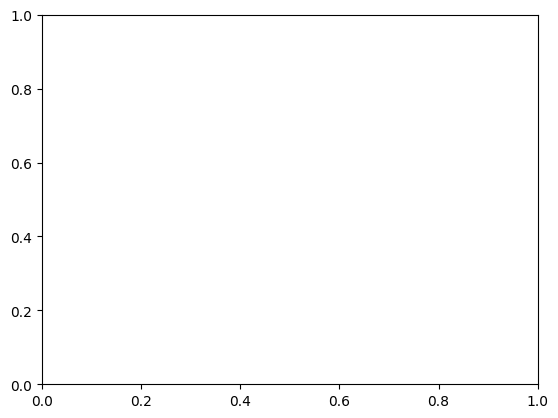

In [ ]:
genCNN.smooth_curve(0.8, num_generations)

In [ ]:
genCNN.gen_acc

[88.54166865348816,
 90.27777910232544,
 91.66666865348816,
 90.27777910232544,
 90.27777910232544]

In [ ]:
import joblib

In [ ]:
joblib.dump(images, "images.joblib")
joblib.dump(Y_train, "Y_train.joblib")

['Y_train.joblib']

In [ ]:
joblib.dump(images, "images.joblib")

['images.joblib']

In [ ]:
images = joblib.load("images.joblib")

In [ ]:
Y_train = joblib.load("Y_train.joblib")

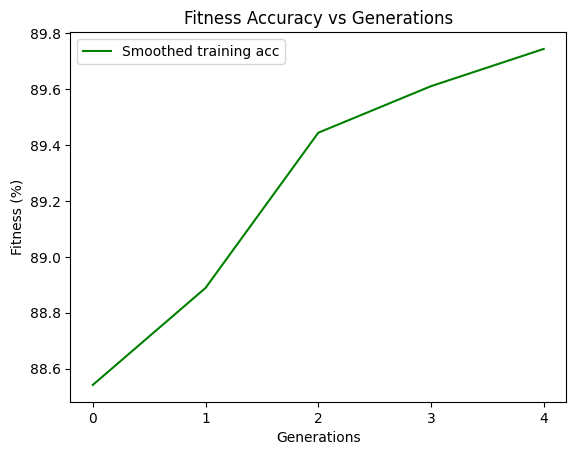

In [ ]:
smooth_curve(0.8, num_generations, genCNN.gen_acc)

In [162]:
# from numba import cuda
#
# device = cuda.get_current_device()
# device.reset()

ModuleNotFoundError: No module named 'numba'

In [ ]:
# images.shape

In [ ]:
# genCNN.best_arch

array([66, 40, 88,  3,  1,  1])

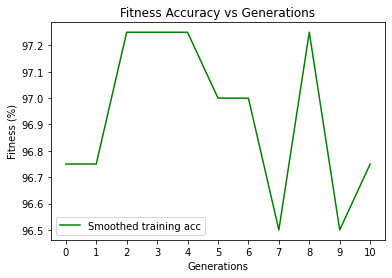

In [ ]:
genCNN.smooth_curve(0, 10)

# **Keras Tuner**

In [ ]:
from kerastuner import RandomSearch

In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def ktuner(hp):
    model = Sequential(
        [
            Conv2D(
                filters=hp.Int("conv_1_filter", min_value=10, max_value=100, step=5),
                kernel_size=hp.Choice("conv_1_kernel", values=[1, 3, 5, 7, 10]),
                activation="relu",
                padding="same",
                input_shape=(112, 92, 1),
            ),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(
                filters=hp.Int("conv_2_filter", min_value=10, max_value=100, step=5),
                kernel_size=hp.Choice("conv_2_kernel", values=[1, 3, 5, 7, 10]),
                activation="relu",
                padding="same",
            ),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(
                filters=hp.Int("conv_3_filter", min_value=10, max_value=100, step=5),
                kernel_size=hp.Choice("conv_3_kernel", values=[1, 3, 5, 7, 10]),
                activation="relu",
                padding="same",
            ),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Flatten(),
            Dropout(0.3),
            Dense(512, activation="relu"),
            Dense(40, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [ ]:
tuner_search = RandomSearch(
    ktuner,
    objective="accuracy",
    max_trials=25,
    directory="output3",
    project_name="keras tuner AT&T Face Dataset",
)

In [ ]:
tuner_search.search(images, Y_train, epochs=5)

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 11s - loss: 3.5615 - accuracy: 0.0000e+0 - ETA: 3s - loss: 3.6655 - accuracy: 0.0104    - ETA: 1s - loss: 3.6304 - accuracy: 0.01 - ETA: 0s - loss: 3.6308 - accuracy: 0.01 - ETA: 0s - loss: 3.6312 - accuracy: 0.01 - ETA: 0s - loss: 3.6210 - accuracy: 0.01 - 3s 8ms/sample - loss: 3.6292 - accuracy: 0.0125
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6870 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.6294 - accuracy: 0.0312   - ETA: 0s - loss: 3.5968 - accuracy: 0.02 - ETA: 0s - loss: 3.6242 - accuracy: 0.02 - ETA: 0s - loss: 3.6105 - accuracy: 0.02 - ETA: 0s - loss: 3.6029 - accuracy: 0.01 - 2s 5ms/sample - loss: 3.6056 - accuracy: 0.0275
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.4499 - accuracy: 0.06 - ETA: 0s - loss: 3.4766 - accuracy: 0.06 - ETA: 0s - loss: 3.5248 - accuracy: 0.05 - ETA: 0s - loss: 3.4981 - accuracy: 0.06 - ETA: 0s - loss: 3.5287 - accuracy

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.5629 - accuracy: 0.0000e+ - ETA: 1s - loss: 3.6247 - accuracy: 0.0156   - ETA: 0s - loss: 3.6112 - accuracy: 0.01 - ETA: 0s - loss: 3.6101 - accuracy: 0.02 - 4s 9ms/sample - loss: 3.6152 - accuracy: 0.0250
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6600 - accuracy: 0.18 - ETA: 0s - loss: 3.5657 - accuracy: 0.15 - ETA: 0s - loss: 3.5574 - accuracy: 0.12 - ETA: 0s - loss: 3.5290 - accuracy: 0.10 - 2s 5ms/sample - loss: 3.5198 - accuracy: 0.1225
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2221 - accuracy: 0.40 - ETA: 0s - loss: 3.2935 - accuracy: 0.20 - ETA: 0s - loss: 3.2376 - accuracy: 0.18 - ETA: 0s - loss: 3.2260 - accuracy: 0.22 - 2s 5ms/sample - loss: 3.1727 - accuracy: 0.2850
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 2.6334 - accuracy: 0.78 - ETA: 0s - loss: 2.5668 - accuracy: 0.60 - ETA: 0s - loss: 2.3759 - ac

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.5974 - accuracy: 0.0000e+ - ETA: 2s - loss: 3.5657 - accuracy: 0.0104   - ETA: 1s - loss: 3.5722 - accuracy: 0.01 - ETA: 0s - loss: 3.5895 - accuracy: 0.01 - ETA: 0s - loss: 3.5983 - accuracy: 0.01 - ETA: 0s - loss: 3.5938 - accuracy: 0.01 - 3s 7ms/sample - loss: 3.6061 - accuracy: 0.0225
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6706 - accuracy: 0.15 - ETA: 0s - loss: 3.6187 - accuracy: 0.15 - ETA: 0s - loss: 3.5282 - accuracy: 0.13 - ETA: 0s - loss: 3.5677 - accuracy: 0.09 - ETA: 0s - loss: 3.5447 - accuracy: 0.09 - ETA: 0s - loss: 3.5208 - accuracy: 0.08 - 3s 6ms/sample - loss: 3.5145 - accuracy: 0.0775
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.1222 - accuracy: 0.12 - ETA: 0s - loss: 3.0829 - accuracy: 0.21 - ETA: 0s - loss: 3.1015 - accuracy: 0.22 - ETA: 0s - loss: 2.9571 - accuracy: 0.24 - ETA: 0s - loss: 2.8969 - accuracy: 0.26 - ET

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 7s - loss: 3.5722 - accuracy: 0.0000e+ - ETA: 1s - loss: 3.5605 - accuracy: 0.0125   - ETA: 0s - loss: 3.5882 - accuracy: 0.01 - 2s 4ms/sample - loss: 3.5917 - accuracy: 0.0325
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6139 - accuracy: 0.18 - ETA: 0s - loss: 3.4614 - accuracy: 0.16 - ETA: 0s - loss: 3.4581 - accuracy: 0.14 - 1s 2ms/sample - loss: 3.4129 - accuracy: 0.1825
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 2.9728 - accuracy: 0.46 - ETA: 0s - loss: 3.0002 - accuracy: 0.35 - ETA: 0s - loss: 2.8905 - accuracy: 0.36 - 1s 2ms/sample - loss: 2.7769 - accuracy: 0.4450
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 2.1774 - accuracy: 0.75 - ETA: 0s - loss: 1.9537 - accuracy: 0.65 - ETA: 0s - loss: 1.7007 - accuracy: 0.69 - 1s 2ms/sample - loss: 1.5657 - accuracy: 0.7025
Epoch 5/5
400/400 [==============================] - ETA: 0s - 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 12s - loss: 3.5739 - accuracy: 0.062 - ETA: 3s - loss: 3.5660 - accuracy: 0.031 - ETA: 1s - loss: 3.5840 - accuracy: 0.02 - ETA: 1s - loss: 3.6038 - accuracy: 0.01 - ETA: 0s - loss: 3.6116 - accuracy: 0.01 - ETA: 0s - loss: 3.6059 - accuracy: 0.01 - 4s 9ms/sample - loss: 3.6179 - accuracy: 0.0175
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6739 - accuracy: 0.03 - ETA: 0s - loss: 3.6416 - accuracy: 0.04 - ETA: 0s - loss: 3.5524 - accuracy: 0.05 - ETA: 0s - loss: 3.5828 - accuracy: 0.05 - ETA: 0s - loss: 3.5668 - accuracy: 0.04 - ETA: 0s - loss: 3.5548 - accuracy: 0.05 - 2s 4ms/sample - loss: 3.5509 - accuracy: 0.0450
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2009 - accuracy: 0.21 - ETA: 0s - loss: 3.2185 - accuracy: 0.11 - ETA: 0s - loss: 3.2352 - accuracy: 0.15 - ETA: 0s - loss: 3.1264 - accuracy: 0.18 - ETA: 0s - loss: 3.0668 - accuracy: 0.22 - ETA: 0s

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 7s - loss: 3.5698 - accuracy: 0.0000e+ - ETA: 1s - loss: 3.6186 - accuracy: 0.0156   - ETA: 0s - loss: 3.6058 - accuracy: 0.00 - ETA: 0s - loss: 3.6084 - accuracy: 0.01 - 2s 6ms/sample - loss: 3.6142 - accuracy: 0.0150
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6657 - accuracy: 0.09 - ETA: 0s - loss: 3.5663 - accuracy: 0.08 - ETA: 0s - loss: 3.5739 - accuracy: 0.07 - ETA: 0s - loss: 3.5459 - accuracy: 0.09 - 2s 4ms/sample - loss: 3.5394 - accuracy: 0.0825
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2409 - accuracy: 0.12 - ETA: 0s - loss: 3.2384 - accuracy: 0.24 - ETA: 0s - loss: 3.1138 - accuracy: 0.23 - ETA: 0s - loss: 3.0186 - accuracy: 0.25 - 2s 5ms/sample - loss: 2.9303 - accuracy: 0.2650
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 2.1708 - accuracy: 0.40 - ETA: 0s - loss: 1.9940 - accuracy: 0.47 - ETA: 0s - loss: 1.8118 - ac

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 9s - loss: 3.5588 - accuracy: 0.0000e+ - ETA: 2s - loss: 3.5676 - accuracy: 0.0208   - ETA: 1s - loss: 3.5869 - accuracy: 0.01 - ETA: 0s - loss: 3.6001 - accuracy: 0.02 - ETA: 0s - loss: 3.6071 - accuracy: 0.02 - ETA: 0s - loss: 3.6015 - accuracy: 0.01 - 2s 6ms/sample - loss: 3.6128 - accuracy: 0.0175
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6820 - accuracy: 0.03 - ETA: 0s - loss: 3.6414 - accuracy: 0.06 - ETA: 0s - loss: 3.5666 - accuracy: 0.05 - ETA: 0s - loss: 3.5989 - accuracy: 0.04 - ETA: 0s - loss: 3.5828 - accuracy: 0.03 - ETA: 0s - loss: 3.5833 - accuracy: 0.05 - 1s 3ms/sample - loss: 3.5757 - accuracy: 0.0525
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.3676 - accuracy: 0.03 - ETA: 0s - loss: 3.4092 - accuracy: 0.08 - ETA: 0s - loss: 3.4450 - accuracy: 0.08 - ETA: 0s - loss: 3.4041 - accuracy: 0.08 - ETA: 0s - loss: 3.4191 - accuracy: 0.11 - ET

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 14s - loss: 3.5765 - accuracy: 0.0000e+0 - ETA: 6s - loss: 3.6055 - accuracy: 0.0000e+0 - ETA: 4s - loss: 3.5678 - accuracy: 0.0000e+ - ETA: 3s - loss: 3.5998 - accuracy: 0.0078   - ETA: 2s - loss: 3.5782 - accuracy: 0.00 - ETA: 1s - loss: 3.5764 - accuracy: 0.01 - ETA: 1s - loss: 3.5925 - accuracy: 0.01 - ETA: 0s - loss: 3.5901 - accuracy: 0.01 - ETA: 0s - loss: 3.6007 - accuracy: 0.01 - ETA: 0s - loss: 3.5974 - accuracy: 0.01 - ETA: 0s - loss: 3.5971 - accuracy: 0.01 - ETA: 0s - loss: 3.6087 - accuracy: 0.01 - 3s 8ms/sample - loss: 3.6134 - accuracy: 0.0175
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6852 - accuracy: 0.03 - ETA: 0s - loss: 3.6847 - accuracy: 0.03 - ETA: 0s - loss: 3.6467 - accuracy: 0.02 - ETA: 0s - loss: 3.5995 - accuracy: 0.03 - ETA: 0s - loss: 3.5711 - accuracy: 0.03 - ETA: 0s - loss: 3.5902 - accuracy: 0.03 - ETA: 0s - loss: 3.6040 - accuracy: 0.03 - ETA: 0s 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 11s - loss: 3.5697 - accuracy: 0.0000e+0 - ETA: 3s - loss: 3.5533 - accuracy: 0.0000e+0 - ETA: 1s - loss: 3.5675 - accuracy: 0.0063   - ETA: 0s - loss: 3.5869 - accuracy: 0.00 - ETA: 0s - loss: 3.5962 - accuracy: 0.00 - ETA: 0s - loss: 3.5926 - accuracy: 0.00 - 4s 9ms/sample - loss: 3.6045 - accuracy: 0.0100
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6832 - accuracy: 0.12 - ETA: 0s - loss: 3.6357 - accuracy: 0.11 - ETA: 0s - loss: 3.5653 - accuracy: 0.07 - ETA: 0s - loss: 3.5924 - accuracy: 0.05 - ETA: 0s - loss: 3.5741 - accuracy: 0.05 - ETA: 0s - loss: 3.5649 - accuracy: 0.04 - 2s 4ms/sample - loss: 3.5618 - accuracy: 0.0450
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2732 - accuracy: 0.28 - ETA: 0s - loss: 3.3026 - accuracy: 0.17 - ETA: 0s - loss: 3.3437 - accuracy: 0.13 - ETA: 0s - loss: 3.2940 - accuracy: 0.14 - ETA: 0s - loss: 3.2811 - accuracy: 0.

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 7s - loss: 3.5662 - accuracy: 0.03 - ETA: 1s - loss: 3.6225 - accuracy: 0.03 - ETA: 0s - loss: 3.5906 - accuracy: 0.02 - ETA: 0s - loss: 3.6006 - accuracy: 0.01 - ETA: 0s - loss: 3.6046 - accuracy: 0.01 - 2s 5ms/sample - loss: 3.6145 - accuracy: 0.0150
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6800 - accuracy: 0.09 - ETA: 0s - loss: 3.5857 - accuracy: 0.14 - ETA: 0s - loss: 3.5731 - accuracy: 0.12 - ETA: 0s - loss: 3.5917 - accuracy: 0.10 - ETA: 0s - loss: 3.5584 - accuracy: 0.08 - 1s 3ms/sample - loss: 3.5682 - accuracy: 0.0725
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.3375 - accuracy: 0.06 - ETA: 0s - loss: 3.4066 - accuracy: 0.14 - ETA: 0s - loss: 3.3786 - accuracy: 0.16 - ETA: 0s - loss: 3.3447 - accuracy: 0.18 - ETA: 0s - loss: 3.3503 - accuracy: 0.17 - ETA: 0s - loss: 3.3042 - accuracy: 0.20 - 1s 3ms/sample - loss: 3.2822 - accuracy: 0.2150
Epoc

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 11s - loss: 3.5737 - accuracy: 0.031 - ETA: 3s - loss: 3.8055 - accuracy: 0.020 - ETA: 1s - loss: 3.7231 - accuracy: 0.01 - ETA: 0s - loss: 3.6985 - accuracy: 0.01 - ETA: 0s - loss: 3.6834 - accuracy: 0.01 - ETA: 0s - loss: 3.6636 - accuracy: 0.00 - 4s 11ms/sample - loss: 3.6668 - accuracy: 0.0075
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6889 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.6494 - accuracy: 0.0208   - ETA: 0s - loss: 3.5729 - accuracy: 0.01 - ETA: 0s - loss: 3.6061 - accuracy: 0.01 - ETA: 0s - loss: 3.5985 - accuracy: 0.02 - ETA: 0s - loss: 3.5934 - accuracy: 0.02 - 2s 5ms/sample - loss: 3.5975 - accuracy: 0.0225
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.4480 - accuracy: 0.03 - ETA: 0s - loss: 3.4805 - accuracy: 0.03 - ETA: 0s - loss: 3.5432 - accuracy: 0.01 - ETA: 0s - loss: 3.5285 - accuracy: 0.03 - ETA: 0s - loss: 3.5615 - accuracy: 0.02 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.5801 - accuracy: 0.0000e+ - ETA: 1s - loss: 3.5965 - accuracy: 0.0078   - ETA: 0s - loss: 3.5895 - accuracy: 0.00 - ETA: 0s - loss: 3.5991 - accuracy: 0.00 - ETA: 0s - loss: 3.5949 - accuracy: 0.00 - 4s 10ms/sample - loss: 3.6063 - accuracy: 0.0050
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6863 - accuracy: 0.03 - ETA: 0s - loss: 3.6446 - accuracy: 0.05 - ETA: 0s - loss: 3.5873 - accuracy: 0.04 - ETA: 0s - loss: 3.5884 - accuracy: 0.03 - ETA: 0s - loss: 3.5802 - accuracy: 0.03 - 2s 4ms/sample - loss: 3.5797 - accuracy: 0.0300
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.3369 - accuracy: 0.18 - ETA: 0s - loss: 3.3706 - accuracy: 0.13 - ETA: 0s - loss: 3.4265 - accuracy: 0.12 - ETA: 0s - loss: 3.3971 - accuracy: 0.15 - ETA: 0s - loss: 3.3807 - accuracy: 0.15 - ETA: 0s - loss: 3.3570 - accuracy: 0.16 - 2s 4ms/sample - loss: 3.3394 - accuracy: 0.

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.5657 - accuracy: 0.09 - ETA: 2s - loss: 3.5742 - accuracy: 0.04 - ETA: 1s - loss: 3.5956 - accuracy: 0.02 - ETA: 0s - loss: 3.6066 - accuracy: 0.02 - ETA: 0s - loss: 3.6127 - accuracy: 0.02 - ETA: 0s - loss: 3.6058 - accuracy: 0.02 - 3s 7ms/sample - loss: 3.6157 - accuracy: 0.0275
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6762 - accuracy: 0.06 - ETA: 0s - loss: 3.6279 - accuracy: 0.06 - ETA: 0s - loss: 3.5488 - accuracy: 0.04 - ETA: 0s - loss: 3.5764 - accuracy: 0.04 - ETA: 0s - loss: 3.5667 - accuracy: 0.03 - ETA: 0s - loss: 3.5523 - accuracy: 0.05 - 2s 5ms/sample - loss: 3.5540 - accuracy: 0.0450
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2431 - accuracy: 0.03 - ETA: 0s - loss: 3.2875 - accuracy: 0.08 - ETA: 0s - loss: 3.3346 - accuracy: 0.11 - ETA: 0s - loss: 3.2628 - accuracy: 0.12 - ETA: 0s - loss: 3.2578 - accuracy: 0.14 - ETA: 0s - 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 20s - loss: 3.5762 - accuracy: 0.0000e+0 - ETA: 9s - loss: 4.4563 - accuracy: 0.0000e+0 - ETA: 6s - loss: 4.1201 - accuracy: 0.0208   - ETA: 4s - loss: 4.0185 - accuracy: 0.01 - ETA: 3s - loss: 3.9078 - accuracy: 0.01 - ETA: 2s - loss: 3.8553 - accuracy: 0.01 - ETA: 1s - loss: 3.8338 - accuracy: 0.00 - ETA: 1s - loss: 3.8003 - accuracy: 0.01 - ETA: 1s - loss: 3.7903 - accuracy: 0.01 - ETA: 0s - loss: 3.7685 - accuracy: 0.01 - ETA: 0s - loss: 3.7493 - accuracy: 0.01 - ETA: 0s - loss: 3.7448 - accuracy: 0.01 - 5s 12ms/sample - loss: 3.7423 - accuracy: 0.0125
Epoch 2/5
400/400 [==============================] - ETA: 1s - loss: 3.6766 - accuracy: 0.03 - ETA: 1s - loss: 3.6752 - accuracy: 0.01 - ETA: 0s - loss: 3.6455 - accuracy: 0.02 - ETA: 0s - loss: 3.5851 - accuracy: 0.06 - ETA: 0s - loss: 3.5473 - accuracy: 0.05 - ETA: 0s - loss: 3.5698 - accuracy: 0.04 - ETA: 0s - loss: 3.5813 - accuracy: 0.04 - ETA: 0s - l

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 9s - loss: 3.5711 - accuracy: 0.06 - ETA: 2s - loss: 3.5610 - accuracy: 0.03 - ETA: 1s - loss: 3.5847 - accuracy: 0.03 - ETA: 0s - loss: 3.5990 - accuracy: 0.03 - ETA: 0s - loss: 3.6058 - accuracy: 0.03 - ETA: 0s - loss: 3.5998 - accuracy: 0.03 - 3s 7ms/sample - loss: 3.6105 - accuracy: 0.0275
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6805 - accuracy: 0.06 - ETA: 0s - loss: 3.6349 - accuracy: 0.07 - ETA: 0s - loss: 3.5560 - accuracy: 0.05 - ETA: 0s - loss: 3.5843 - accuracy: 0.04 - ETA: 0s - loss: 3.5643 - accuracy: 0.03 - ETA: 0s - loss: 3.5495 - accuracy: 0.03 - 2s 4ms/sample - loss: 3.5393 - accuracy: 0.0625
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.1876 - accuracy: 0.25 - ETA: 0s - loss: 3.2112 - accuracy: 0.15 - ETA: 0s - loss: 3.2204 - accuracy: 0.15 - ETA: 0s - loss: 3.1093 - accuracy: 0.18 - ETA: 0s - loss: 3.0556 - accuracy: 0.20 - ETA: 0s - 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 6s - loss: 3.5694 - accuracy: 0.06 - ETA: 1s - loss: 3.5976 - accuracy: 0.03 - ETA: 0s - loss: 3.5957 - accuracy: 0.03 - ETA: 0s - loss: 3.6015 - accuracy: 0.03 - 2s 5ms/sample - loss: 3.6075 - accuracy: 0.0350
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6488 - accuracy: 0.12 - ETA: 0s - loss: 3.5335 - accuracy: 0.12 - ETA: 0s - loss: 3.5291 - accuracy: 0.12 - ETA: 0s - loss: 3.4861 - accuracy: 0.11 - 2s 4ms/sample - loss: 3.4727 - accuracy: 0.1025
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.0811 - accuracy: 0.31 - ETA: 0s - loss: 3.1370 - accuracy: 0.24 - ETA: 0s - loss: 3.0347 - accuracy: 0.27 - ETA: 0s - loss: 2.9722 - accuracy: 0.32 - 2s 5ms/sample - loss: 2.8838 - accuracy: 0.3475
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 2.1271 - accuracy: 0.62 - ETA: 0s - loss: 2.0154 - accuracy: 0.54 - ETA: 0s - loss: 1.8150 - accuracy: 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 16s - loss: 3.5786 - accuracy: 0.062 - ETA: 7s - loss: 3.6017 - accuracy: 0.031 - ETA: 5s - loss: 3.5575 - accuracy: 0.04 - ETA: 3s - loss: 3.5889 - accuracy: 0.03 - ETA: 2s - loss: 3.5692 - accuracy: 0.03 - ETA: 1s - loss: 3.5697 - accuracy: 0.02 - ETA: 1s - loss: 3.5868 - accuracy: 0.02 - ETA: 1s - loss: 3.5856 - accuracy: 0.01 - ETA: 0s - loss: 3.5971 - accuracy: 0.01 - ETA: 0s - loss: 3.5949 - accuracy: 0.01 - ETA: 0s - loss: 3.5931 - accuracy: 0.01 - ETA: 0s - loss: 3.6013 - accuracy: 0.01 - 4s 10ms/sample - loss: 3.6049 - accuracy: 0.0150
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6881 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.6873 - accuracy: 0.0312   - ETA: 0s - loss: 3.6487 - accuracy: 0.03 - ETA: 0s - loss: 3.6011 - accuracy: 0.02 - ETA: 0s - loss: 3.5725 - accuracy: 0.01 - ETA: 0s - loss: 3.5917 - accuracy: 0.01 - ETA: 0s - loss: 3.6051 - accuracy: 0.01 - ETA: 0s - loss:

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.6006 - accuracy: 0.0000e+ - ETA: 2s - loss: 3.5556 - accuracy: 0.0104   - ETA: 1s - loss: 3.5709 - accuracy: 0.01 - ETA: 0s - loss: 3.5882 - accuracy: 0.02 - ETA: 0s - loss: 3.5976 - accuracy: 0.02 - ETA: 0s - loss: 3.5932 - accuracy: 0.02 - 4s 10ms/sample - loss: 3.6047 - accuracy: 0.0250
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6694 - accuracy: 0.12 - ETA: 0s - loss: 3.6089 - accuracy: 0.13 - ETA: 0s - loss: 3.5448 - accuracy: 0.11 - ETA: 0s - loss: 3.5708 - accuracy: 0.10 - ETA: 0s - loss: 3.5555 - accuracy: 0.09 - ETA: 0s - loss: 3.5307 - accuracy: 0.09 - 2s 4ms/sample - loss: 3.5138 - accuracy: 0.0950
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 2.9665 - accuracy: 0.21 - ETA: 0s - loss: 2.8935 - accuracy: 0.22 - ETA: 0s - loss: 2.8729 - accuracy: 0.18 - ETA: 0s - loss: 2.6219 - accuracy: 0.24 - ETA: 0s - loss: 2.5075 - accuracy: 0.27 - E

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 9s - loss: 3.5676 - accuracy: 0.06 - ETA: 2s - loss: 3.5856 - accuracy: 0.03 - ETA: 1s - loss: 3.5946 - accuracy: 0.02 - ETA: 0s - loss: 3.6103 - accuracy: 0.03 - ETA: 0s - loss: 3.6175 - accuracy: 0.02 - ETA: 0s - loss: 3.6124 - accuracy: 0.01 - 3s 8ms/sample - loss: 3.6226 - accuracy: 0.0175
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6642 - accuracy: 0.09 - ETA: 0s - loss: 3.6190 - accuracy: 0.06 - ETA: 0s - loss: 3.5421 - accuracy: 0.05 - ETA: 0s - loss: 3.5813 - accuracy: 0.04 - ETA: 0s - loss: 3.5697 - accuracy: 0.05 - ETA: 0s - loss: 3.5599 - accuracy: 0.05 - 2s 4ms/sample - loss: 3.5596 - accuracy: 0.0525
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2745 - accuracy: 0.15 - ETA: 0s - loss: 3.2919 - accuracy: 0.11 - ETA: 0s - loss: 3.3371 - accuracy: 0.09 - ETA: 0s - loss: 3.2740 - accuracy: 0.09 - ETA: 0s - loss: 3.2843 - accuracy: 0.10 - ETA: 0s - 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 6s - loss: 3.5701 - accuracy: 0.03 - ETA: 1s - loss: 3.6389 - accuracy: 0.03 - ETA: 0s - loss: 3.6234 - accuracy: 0.03 - ETA: 0s - loss: 3.6172 - accuracy: 0.02 - 2s 6ms/sample - loss: 3.6183 - accuracy: 0.0300
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6267 - accuracy: 0.09 - ETA: 0s - loss: 3.5086 - accuracy: 0.15 - ETA: 0s - loss: 3.4930 - accuracy: 0.15 - ETA: 0s - loss: 3.4527 - accuracy: 0.15 - 1s 4ms/sample - loss: 3.4283 - accuracy: 0.1625
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 2.9463 - accuracy: 0.40 - ETA: 0s - loss: 2.9954 - accuracy: 0.31 - ETA: 0s - loss: 2.8488 - accuracy: 0.43 - ETA: 0s - loss: 2.7554 - accuracy: 0.47 - 2s 4ms/sample - loss: 2.6277 - accuracy: 0.5075
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 1.7637 - accuracy: 0.75 - ETA: 0s - loss: 1.4846 - accuracy: 0.75 - ETA: 0s - loss: 1.2530 - accuracy: 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 10s - loss: 3.5751 - accuracy: 0.0000e+0 - ETA: 3s - loss: 3.5303 - accuracy: 0.0208    - ETA: 1s - loss: 3.5927 - accuracy: 0.01 - ETA: 0s - loss: 3.6014 - accuracy: 0.01 - ETA: 0s - loss: 3.6084 - accuracy: 0.01 - ETA: 0s - loss: 3.6028 - accuracy: 0.01 - 2s 5ms/sample - loss: 3.6156 - accuracy: 0.0150
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6866 - accuracy: 0.03 - ETA: 0s - loss: 3.6468 - accuracy: 0.05 - ETA: 0s - loss: 3.5690 - accuracy: 0.03 - ETA: 0s - loss: 3.6058 - accuracy: 0.03 - ETA: 0s - loss: 3.5963 - accuracy: 0.03 - ETA: 0s - loss: 3.5895 - accuracy: 0.02 - 2s 4ms/sample - loss: 3.5896 - accuracy: 0.0275
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.06 - ETA: 0s - loss: 3.4116 - accuracy: 0.04 - ETA: 0s - loss: 3.4582 - accuracy: 0.07 - ETA: 0s - loss: 3.4159 - accuracy: 0.10 - ETA: 0s - loss: 3.4202 - accuracy: 0.10 -

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.5783 - accuracy: 0.03 - ETA: 2s - loss: 3.5712 - accuracy: 0.02 - ETA: 1s - loss: 3.5785 - accuracy: 0.01 - ETA: 0s - loss: 3.5972 - accuracy: 0.01 - ETA: 0s - loss: 3.6053 - accuracy: 0.01 - ETA: 0s - loss: 3.6009 - accuracy: 0.01 - 4s 10ms/sample - loss: 3.6122 - accuracy: 0.0125
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6817 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.6401 - accuracy: 0.0417   - ETA: 0s - loss: 3.5617 - accuracy: 0.03 - ETA: 0s - loss: 3.5895 - accuracy: 0.04 - ETA: 0s - loss: 3.5719 - accuracy: 0.04 - ETA: 0s - loss: 3.5589 - accuracy: 0.04 - 1s 3ms/sample - loss: 3.5677 - accuracy: 0.0450
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.3129 - accuracy: 0.03 - ETA: 0s - loss: 3.3301 - accuracy: 0.06 - ETA: 0s - loss: 3.3861 - accuracy: 0.06 - ETA: 0s - loss: 3.3237 - accuracy: 0.09 - ETA: 0s - loss: 3.3278 - accuracy: 0.12 - E

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 7s - loss: 3.5895 - accuracy: 0.0000e+ - ETA: 2s - loss: 3.5544 - accuracy: 0.0104   - ETA: 1s - loss: 3.5728 - accuracy: 0.01 - ETA: 0s - loss: 3.5899 - accuracy: 0.00 - ETA: 0s - loss: 3.6002 - accuracy: 0.01 - ETA: 0s - loss: 3.5954 - accuracy: 0.01 - 2s 5ms/sample - loss: 3.6066 - accuracy: 0.0100
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6789 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.6288 - accuracy: 0.0312   - ETA: 0s - loss: 3.5707 - accuracy: 0.03 - ETA: 0s - loss: 3.5969 - accuracy: 0.03 - ETA: 0s - loss: 3.5843 - accuracy: 0.04 - ETA: 0s - loss: 3.5751 - accuracy: 0.04 - 1s 3ms/sample - loss: 3.5747 - accuracy: 0.0450
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.4040 - accuracy: 0.09 - ETA: 0s - loss: 3.4035 - accuracy: 0.04 - ETA: 0s - loss: 3.4192 - accuracy: 0.05 - ETA: 0s - loss: 3.3870 - accuracy: 0.08 - ETA: 0s - loss: 3.4083 - accuracy: 0

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 8s - loss: 3.5960 - accuracy: 0.03 - ETA: 1s - loss: 3.6068 - accuracy: 0.01 - ETA: 0s - loss: 3.5920 - accuracy: 0.01 - ETA: 0s - loss: 3.5989 - accuracy: 0.01 - 3s 7ms/sample - loss: 3.6053 - accuracy: 0.0300
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6563 - accuracy: 0.09 - ETA: 0s - loss: 3.5456 - accuracy: 0.07 - ETA: 0s - loss: 3.5253 - accuracy: 0.06 - ETA: 0s - loss: 3.4717 - accuracy: 0.08 - 1s 3ms/sample - loss: 3.4084 - accuracy: 0.0850
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 2.8938 - accuracy: 0.12 - ETA: 0s - loss: 2.5808 - accuracy: 0.25 - ETA: 0s - loss: 2.3476 - accuracy: 0.29 - ETA: 0s - loss: 2.2485 - accuracy: 0.33 - 1s 3ms/sample - loss: 2.0935 - accuracy: 0.3775
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.68 - ETA: 0s - loss: 1.1641 - accuracy: 0.64 - ETA: 0s - loss: 1.0356 - accuracy: 

Train on 400 samples
Epoch 1/5
400/400 [==============================] - ETA: 10s - loss: 3.5746 - accuracy: 0.031 - ETA: 3s - loss: 3.5814 - accuracy: 0.031 - ETA: 1s - loss: 3.5960 - accuracy: 0.02 - ETA: 0s - loss: 3.6078 - accuracy: 0.01 - ETA: 0s - loss: 3.6153 - accuracy: 0.01 - ETA: 0s - loss: 3.6089 - accuracy: 0.01 - 7s 18ms/sample - loss: 3.6187 - accuracy: 0.0200
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 3.6799 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.6314 - accuracy: 0.0312   - ETA: 0s - loss: 3.5411 - accuracy: 0.05 - ETA: 0s - loss: 3.5703 - accuracy: 0.04 - ETA: 0s - loss: 3.5485 - accuracy: 0.04 - ETA: 0s - loss: 3.5363 - accuracy: 0.04 - 2s 5ms/sample - loss: 3.5439 - accuracy: 0.0400
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 3.2421 - accuracy: 0.09 - ETA: 0s - loss: 3.3048 - accuracy: 0.08 - ETA: 0s - loss: 3.3614 - accuracy: 0.07 - ETA: 0s - loss: 3.3058 - accuracy: 0.10 - ETA: 0s - loss: 3.3147 - accuracy: 0.11 

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_ktmodel = tuner_search.get_best_models(num_models=1)[0]

In [ ]:
best_ktmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 92, 20)       200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 46, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 46, 80)        14480     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 23, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 23, 95)        68495     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 11, 95)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14630)             0

In [ ]:
best_hps = tuner_search.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
ktfilters = [
    best_hps.get("conv_1_filter"),
    best_hps.get("conv_2_filter"),
    best_hps.get("conv_3_filter"),
]

In [ ]:
ktkernels = [
    best_hps.get("conv_1_kernel"),
    best_hps.get("conv_2_kernel"),
    best_hps.get("conv_3_kernel"),
]

In [ ]:
print(ktfilters, ktkernels)

[20, 45, 75] [5, 3, 1]


In [ ]:
model_kt = CNN(ktfilters, ktkernels)

In [ ]:
H = model_kt.fit(images, Y_train, batch_size=32, epochs=20)

Train on 400 samples
Epoch 1/20
400/400 [==============================] - ETA: 6s - loss: 3.5663 - accuracy: 0.0000e+ - ETA: 1s - loss: 3.6408 - accuracy: 0.0156   - ETA: 0s - loss: 3.6253 - accuracy: 0.02 - ETA: 0s - loss: 3.6209 - accuracy: 0.01 - 1s 2ms/sample - loss: 3.6226 - accuracy: 0.0225
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 3.6540 - accuracy: 0.03 - ETA: 0s - loss: 3.5564 - accuracy: 0.10 - ETA: 0s - loss: 3.5472 - accuracy: 0.09 - ETA: 0s - loss: 3.5058 - accuracy: 0.11 - 0s 598us/sample - loss: 3.4824 - accuracy: 0.1350
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 3.0662 - accuracy: 0.34 - ETA: 0s - loss: 3.0968 - accuracy: 0.31 - ETA: 0s - loss: 2.9852 - accuracy: 0.36 - ETA: 0s - loss: 2.9051 - accuracy: 0.38 - 0s 569us/sample - loss: 2.7794 - accuracy: 0.4375
Epoch 4/20
400/400 [==============================] - ETA: 0s - loss: 1.9181 - accuracy: 0.68 - ETA: 0s - loss: 1.6498 - accuracy: 0.68 - ETA: 0s - loss: 1.3

In [ ]:
max(H.history["accuracy"])

0.9575

# **Genetic CNN Model**

In [ ]:
gfilters = genCNN.best_arch[:3]
gkernels = genCNN.best_arch[3:]

In [ ]:
print(gfilters, gkernels)

[66 40 88] [3 1 1]


In [ ]:
model_gen = CNN([66, 40, 88], [3, 1, 1])

In [ ]:
model_gen.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 92, 66)       660       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 46, 66)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 46, 40)        2680      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 23, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 23, 88)        3608      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 11, 88)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13552)             0       

In [ ]:
images = joblib.load("images.joblib")

NameError: name 'joblib' is not defined

In [ ]:
import joblib

Y_train_sk = joblib.load("Y_train_sk.joblib")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpointer = ModelCheckpoint(
    filepath="best_weights_genetic.hdf5", save_best_only=True
)

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
h = model_gen.fit(
    images,
    Y_train_sk,
    batch_size=32,
    epochs=20,
    validation_data=(images, Y_train_sk),
    callbacks=[checkpointer],
)

Train on 400 samples, validate on 400 samples
Epoch 1/20
 32/400 [=>............................] - ETA: 0sWARNING:tensorflow:Can save best model only with val_loss available, skipping.


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node cnn/conv2d/Conv2D (defined at <ipython-input-20-6da4469986cc>:2) ]] [Op:__inference_distributed_function_1279]

Function call stack:
distributed_function


In [ ]:
model_gen.load_weights("best_weights_genetic.hdf5")

In [ ]:
model_gen.evaluate(images, Y_train_sk)[1]

 32/400 [=>............................] - ETA: 17s

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node cnn/conv2d/Conv2D (defined at <ipython-input-16-c33b766a92f7>:1) ]] [Op:__inference_distributed_function_432]

Function call stack:
distributed_function


In [ ]:
y_pred_gen = model_gen.predict(images)

In [ ]:
y_pred_gen = np.array([np.argmax(x) for x in y_pred_gen])

In [ ]:
y_pred_gen = y_pred_gen[:, np.newaxis]

In [ ]:
from sklearn.metrics import confusion_matrix

cm_gen = confusion_matrix(Y_train_argmax, y_pred_gen.reshape(-1))

In [ ]:
Y_train_argmax = np.array([np.argmax(x) for x in Y_train]).reshape(-1)

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Heat Map for Genetic CNN Architecture')

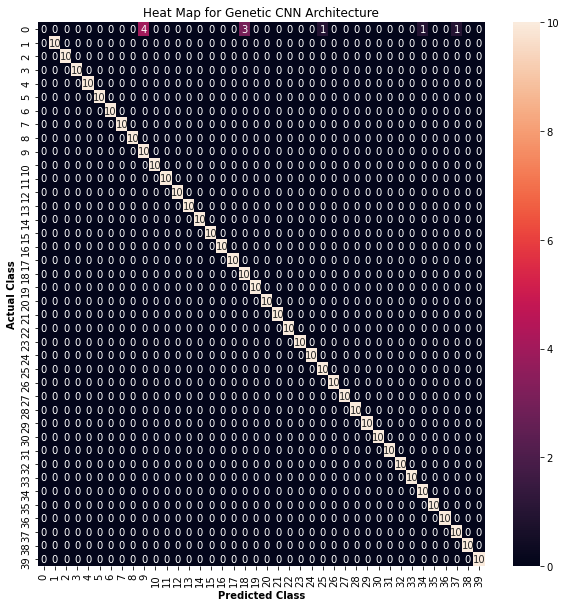

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm_gen, annot=True)
plt.xlabel("Predicted Class", fontweight="bold")
plt.ylabel("Actual Class", fontweight="bold")
plt.title("Heat Map for Genetic CNN Architecture")

In [ ]:
class_pred_acc = []
for i in range(40):
    class_pred_acc.append((cm_gen[i][i] / 10) * 100)

In [ ]:
class_pred_acc = (class_pred_acc).astype("int")

AttributeError: 'list' object has no attribute 'astype'

Text(0.5, 1.0, 'Percentage Classification Accuracy - Genetic CNN')

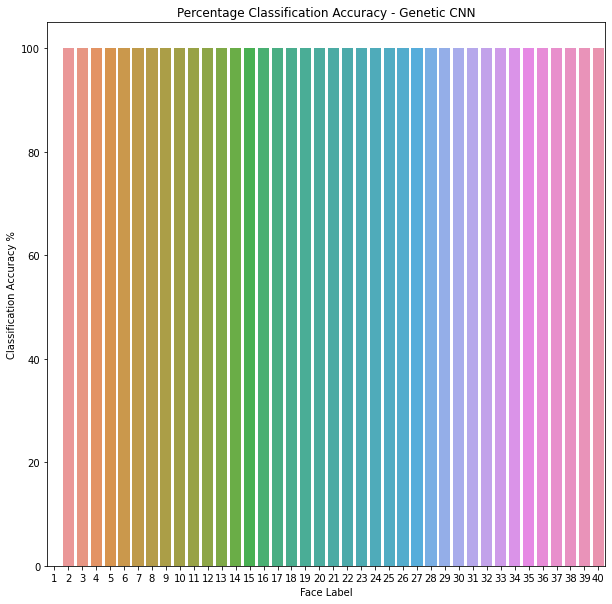

In [ ]:
plt.figure(figsize=(10, 10))
sns.barplot(x=list(range(1, 41)), y=class_pred_acc)
plt.ylabel("Classification Accuracy %")
plt.xlabel("Face Label")
# plt.xticks(['0%','50%','100%'])
plt.title("Percentage Classification Accuracy - Genetic CNN")

In [ ]:
with open("gen_summary.txt", "w") as fh:
    model_gen.summary(print_fn=lambda x: fh.write(x + "\n"))

In [ ]:
pop_first = genCNN.generate_population()

In [ ]:
pop_first

array([[45, 48, 65, 16,  1, 19],
       [68, 68, 10,  4, 18, 15],
       [84, 22, 37,  8,  1,  2],
       [88, 71, 89, 10,  1, 11],
       [89, 13, 59,  4, 12, 19],
       [66, 40, 88,  3,  1,  1],
       [47, 89, 82,  5,  6,  7],
       [38, 26, 78,  9, 18, 16],
       [73, 10, 21,  5, 10, 11],
       [81, 70, 80,  2,  2,  8]])

In [ ]:
pop_acc_first = fitness(pop_first, images, Y_train, 10)

Train on 400 samples
Epoch 1/10
400/400 [==============================] - ETA: 18s - loss: 3.5773 - accuracy: 0.093 - ETA: 10s - loss: 5.3605 - accuracy: 0.046 - ETA: 8s - loss: 4.7580 - accuracy: 0.041 - ETA: 6s - loss: 4.4917 - accuracy: 0.03 - ETA: 5s - loss: 4.2856 - accuracy: 0.03 - ETA: 4s - loss: 4.1670 - accuracy: 0.03 - ETA: 3s - loss: 4.0986 - accuracy: 0.04 - ETA: 2s - loss: 4.0328 - accuracy: 0.03 - ETA: 2s - loss: 3.9950 - accuracy: 0.03 - ETA: 1s - loss: 3.9529 - accuracy: 0.03 - ETA: 0s - loss: 3.9184 - accuracy: 0.02 - ETA: 0s - loss: 3.8993 - accuracy: 0.02 - 7s 18ms/sample - loss: 3.8911 - accuracy: 0.0250
Epoch 2/10
400/400 [==============================] - ETA: 5s - loss: 3.6902 - accuracy: 0.0000e+ - ETA: 5s - loss: 3.6875 - accuracy: 0.0312   - ETA: 4s - loss: 3.6492 - accuracy: 0.02 - ETA: 4s - loss: 3.6009 - accuracy: 0.01 - ETA: 3s - loss: 3.5732 - accuracy: 0.01 - ETA: 3s - loss: 3.5923 - accuracy: 0.01 - ETA: 2s - loss: 3.6067 - accuracy: 0.01 - ETA: 2s - l

400/400 [==============================] - ETA: 3s - loss: 3.6829 - accuracy: 0.0000e+ - ETA: 3s - loss: 3.6190 - accuracy: 0.0000e+ - ETA: 3s - loss: 3.6420 - accuracy: 0.0208   - ETA: 2s - loss: 3.6518 - accuracy: 0.03 - ETA: 2s - loss: 3.6351 - accuracy: 0.02 - ETA: 2s - loss: 3.6207 - accuracy: 0.03 - ETA: 1s - loss: 3.5945 - accuracy: 0.03 - ETA: 1s - loss: 3.6044 - accuracy: 0.03 - ETA: 1s - loss: 3.5864 - accuracy: 0.03 - ETA: 0s - loss: 3.5850 - accuracy: 0.02 - ETA: 0s - loss: 3.5917 - accuracy: 0.02 - ETA: 0s - loss: 3.5962 - accuracy: 0.03 - 4s 10ms/sample - loss: 3.5798 - accuracy: 0.0300
Epoch 5/10
400/400 [==============================] - ETA: 3s - loss: 3.3902 - accuracy: 0.06 - ETA: 3s - loss: 3.3754 - accuracy: 0.09 - ETA: 3s - loss: 3.4723 - accuracy: 0.06 - ETA: 2s - loss: 3.4744 - accuracy: 0.06 - ETA: 2s - loss: 3.4713 - accuracy: 0.05 - ETA: 2s - loss: 3.4712 - accuracy: 0.04 - ETA: 1s - loss: 3.4789 - accuracy: 0.04 - ETA: 1s - loss: 3.5008 - accuracy: 0.03 - ET

400/400 [==============================] - ETA: 1s - loss: 0.3441 - accuracy: 0.93 - ETA: 1s - loss: 0.3113 - accuracy: 0.95 - ETA: 1s - loss: 0.3412 - accuracy: 0.91 - ETA: 1s - loss: 0.2983 - accuracy: 0.91 - ETA: 0s - loss: 0.2740 - accuracy: 0.91 - ETA: 0s - loss: 0.2573 - accuracy: 0.91 - ETA: 0s - loss: 0.2389 - accuracy: 0.91 - ETA: 0s - loss: 0.2211 - accuracy: 0.91 - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - ETA: 0s - loss: 0.1953 - accuracy: 0.92 - ETA: 0s - loss: 0.1926 - accuracy: 0.92 - ETA: 0s - loss: 0.1878 - accuracy: 0.92 - 2s 4ms/sample - loss: 0.1842 - accuracy: 0.9325
Epoch 8/10
400/400 [==============================] - ETA: 1s - loss: 0.0700 - accuracy: 0.90 - ETA: 1s - loss: 0.0791 - accuracy: 0.92 - ETA: 1s - loss: 0.0887 - accuracy: 0.93 - ETA: 1s - loss: 0.0761 - accuracy: 0.94 - ETA: 0s - loss: 0.0725 - accuracy: 0.95 - ETA: 0s - loss: 0.0702 - accuracy: 0.95 - ETA: 0s - loss: 0.0719 - accuracy: 0.95 - ETA: 0s - loss: 0.0744 - accuracy: 0.96 - ETA: 0s - loss:

400/400 [==============================] - ETA: 3s - loss: 0.5246 - accuracy: 0.84 - ETA: 3s - loss: 0.3640 - accuracy: 0.85 - ETA: 3s - loss: 0.2989 - accuracy: 0.86 - ETA: 2s - loss: 0.2580 - accuracy: 0.89 - ETA: 2s - loss: 0.3097 - accuracy: 0.88 - ETA: 2s - loss: 0.3469 - accuracy: 0.87 - ETA: 1s - loss: 0.3670 - accuracy: 0.87 - ETA: 1s - loss: 0.3497 - accuracy: 0.87 - ETA: 1s - loss: 0.3293 - accuracy: 0.87 - ETA: 0s - loss: 0.3250 - accuracy: 0.87 - ETA: 0s - loss: 0.3158 - accuracy: 0.87 - ETA: 0s - loss: 0.3084 - accuracy: 0.87 - 4s 10ms/sample - loss: 0.3007 - accuracy: 0.8800
Train on 400 samples
Epoch 1/10
400/400 [==============================] - ETA: 17s - loss: 3.5598 - accuracy: 0.0000e+0 - ETA: 9s - loss: 5.4200 - accuracy: 0.0000e+0 - ETA: 6s - loss: 4.8138 - accuracy: 0.0104   - ETA: 5s - loss: 4.5329 - accuracy: 0.01 - ETA: 4s - loss: 4.3181 - accuracy: 0.01 - ETA: 3s - loss: 4.1942 - accuracy: 0.01 - ETA: 2s - loss: 4.1220 - accuracy: 0.01 - ETA: 2s - loss: 4.05

400/400 [==============================] - ETA: 2s - loss: 3.2627 - accuracy: 0.18 - ETA: 1s - loss: 3.3505 - accuracy: 0.20 - ETA: 1s - loss: 3.2595 - accuracy: 0.20 - ETA: 1s - loss: 3.3073 - accuracy: 0.20 - ETA: 1s - loss: 3.2997 - accuracy: 0.18 - ETA: 1s - loss: 3.2782 - accuracy: 0.21 - ETA: 0s - loss: 3.2368 - accuracy: 0.24 - ETA: 0s - loss: 3.2321 - accuracy: 0.26 - ETA: 0s - loss: 3.2347 - accuracy: 0.25 - ETA: 0s - loss: 3.2297 - accuracy: 0.24 - ETA: 0s - loss: 3.2058 - accuracy: 0.25 - ETA: 0s - loss: 3.1945 - accuracy: 0.25 - 2s 5ms/sample - loss: 3.1765 - accuracy: 0.2650
Epoch 4/10
400/400 [==============================] - ETA: 2s - loss: 2.6506 - accuracy: 0.68 - ETA: 1s - loss: 2.5486 - accuracy: 0.67 - ETA: 1s - loss: 2.5659 - accuracy: 0.61 - ETA: 1s - loss: 2.5712 - accuracy: 0.56 - ETA: 1s - loss: 2.5082 - accuracy: 0.51 - ETA: 1s - loss: 2.4573 - accuracy: 0.50 - ETA: 0s - loss: 2.3524 - accuracy: 0.52 - ETA: 0s - loss: 2.3191 - accuracy: 0.51 - ETA: 0s - loss:

400/400 [==============================] - ETA: 6s - loss: 0.5005 - accuracy: 0.84 - ETA: 6s - loss: 0.6738 - accuracy: 0.82 - ETA: 5s - loss: 0.5803 - accuracy: 0.83 - ETA: 5s - loss: 0.5394 - accuracy: 0.84 - ETA: 4s - loss: 0.4762 - accuracy: 0.86 - ETA: 3s - loss: 0.4392 - accuracy: 0.86 - ETA: 3s - loss: 0.4180 - accuracy: 0.87 - ETA: 2s - loss: 0.3993 - accuracy: 0.86 - ETA: 2s - loss: 0.3721 - accuracy: 0.87 - ETA: 1s - loss: 0.3558 - accuracy: 0.88 - ETA: 0s - loss: 0.3410 - accuracy: 0.89 - ETA: 0s - loss: 0.3277 - accuracy: 0.89 - 7s 19ms/sample - loss: 0.3207 - accuracy: 0.8925
Epoch 7/10
400/400 [==============================] - ETA: 6s - loss: 0.2461 - accuracy: 0.93 - ETA: 5s - loss: 0.2043 - accuracy: 0.93 - ETA: 4s - loss: 0.1706 - accuracy: 0.93 - ETA: 3s - loss: 0.2176 - accuracy: 0.92 - ETA: 3s - loss: 0.2196 - accuracy: 0.91 - ETA: 2s - loss: 0.2454 - accuracy: 0.91 - ETA: 2s - loss: 0.2221 - accuracy: 0.92 - ETA: 1s - loss: 0.2026 - accuracy: 0.91 - ETA: 1s - loss

400/400 [==============================] - ETA: 3s - loss: 3.1454 - accuracy: 0.12 - ETA: 2s - loss: 3.1528 - accuracy: 0.10 - ETA: 2s - loss: 3.1018 - accuracy: 0.13 - ETA: 2s - loss: 3.0278 - accuracy: 0.13 - ETA: 1s - loss: 2.9296 - accuracy: 0.16 - ETA: 1s - loss: 2.8930 - accuracy: 0.17 - ETA: 1s - loss: 2.8628 - accuracy: 0.17 - ETA: 1s - loss: 2.8385 - accuracy: 0.16 - ETA: 0s - loss: 2.7848 - accuracy: 0.17 - ETA: 0s - loss: 2.7122 - accuracy: 0.19 - ETA: 0s - loss: 2.6308 - accuracy: 0.22 - ETA: 0s - loss: 2.5649 - accuracy: 0.23 - 3s 8ms/sample - loss: 2.5472 - accuracy: 0.2400
Epoch 10/10
400/400 [==============================] - ETA: 3s - loss: 1.9015 - accuracy: 0.37 - ETA: 2s - loss: 1.8979 - accuracy: 0.45 - ETA: 2s - loss: 1.7762 - accuracy: 0.48 - ETA: 2s - loss: 1.6939 - accuracy: 0.51 - ETA: 2s - loss: 1.6162 - accuracy: 0.53 - ETA: 1s - loss: 1.5833 - accuracy: 0.52 - ETA: 1s - loss: 1.5397 - accuracy: 0.52 - ETA: 1s - loss: 1.4689 - accuracy: 0.54 - ETA: 0s - loss

400/400 [==============================] - ETA: 4s - loss: 3.6790 - accuracy: 0.12 - ETA: 4s - loss: 3.6764 - accuracy: 0.09 - ETA: 3s - loss: 3.6370 - accuracy: 0.08 - ETA: 3s - loss: 3.5857 - accuracy: 0.06 - ETA: 2s - loss: 3.5539 - accuracy: 0.06 - ETA: 2s - loss: 3.5707 - accuracy: 0.05 - ETA: 2s - loss: 3.5818 - accuracy: 0.06 - ETA: 1s - loss: 3.5904 - accuracy: 0.05 - ETA: 1s - loss: 3.5698 - accuracy: 0.06 - ETA: 0s - loss: 3.5610 - accuracy: 0.09 - ETA: 0s - loss: 3.5564 - accuracy: 0.09 - ETA: 0s - loss: 3.5557 - accuracy: 0.09 - 5s 12ms/sample - loss: 3.5463 - accuracy: 0.1000
Epoch 3/10
400/400 [==============================] - ETA: 4s - loss: 3.2310 - accuracy: 0.06 - ETA: 3s - loss: 3.2909 - accuracy: 0.06 - ETA: 3s - loss: 3.1939 - accuracy: 0.09 - ETA: 3s - loss: 3.2512 - accuracy: 0.11 - ETA: 2s - loss: 3.2227 - accuracy: 0.14 - ETA: 2s - loss: 3.1850 - accuracy: 0.16 - ETA: 2s - loss: 3.1147 - accuracy: 0.16 - ETA: 1s - loss: 3.0588 - accuracy: 0.19 - ETA: 1s - loss

In [ ]:
pop_acc_first

[0.78, 0.5075, 0.96, 0.92, 0.925, 0.97, 0.9525, 0.58, 0.92, 0.965]

In [ ]:
import numpy as np

Text(0.5, 1.0, 'Percentage Classification Accuracy - Genetic CNN')

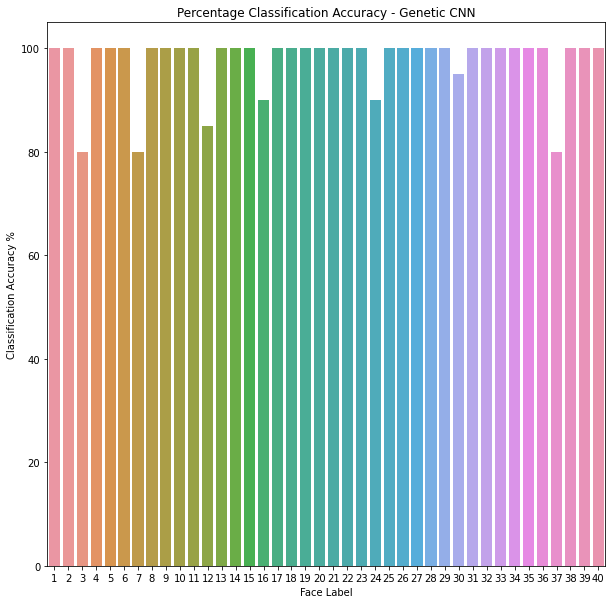

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.barplot(x=list(range(1, 41)), y=b)
plt.ylabel("Classification Accuracy %")
plt.xlabel("Face Label")
# plt.xticks(['0%','50%','100%'])
plt.title("Percentage Classification Accuracy - Genetic CNN")

In [ ]:
pop_size = 10
nlayers = 3
max_nfilters = 100
max_sfilters = 20
epochs = 3
num_generations = 5

genCNN = Genetic(pop_size, nlayers, max_nfilters, max_sfilters)
pop = genCNN.generate_population()

In [ ]:
pop

array([[45, 48, 65, 16,  1, 19],
       [68, 68, 10,  4, 18, 15],
       [84, 22, 37,  8,  1,  2],
       [88, 71, 89, 10,  1, 11],
       [89, 13, 59,  4, 12, 19],
       [66, 40, 88,  3,  1,  1],
       [47, 89, 82,  5,  6,  7],
       [38, 26, 78,  9, 18, 16],
       [73, 10, 21,  5, 10, 11],
       [81, 70, 80,  2,  2,  8]])

In [ ]:
parents = genCNN.select_parents(
    pop, 5, [0.78, 0.5075, 0.96, 0.92, 0.925, 0.97, 0.9525, 0.58, 0.92, 0.965]
)

In [ ]:
parents

array([[66., 40., 88.,  3.,  1.,  1.],
       [81., 70., 80.,  2.,  2.,  8.],
       [84., 22., 37.,  8.,  1.,  2.],
       [47., 89., 82.,  5.,  6.,  7.],
       [89., 13., 59.,  4., 12., 19.]])

In [ ]:
child = genCNN.crossover(parents)

In [ ]:
child

array([[66., 40., 80.,  3.,  1.,  8.],
       [81., 70., 37.,  2.,  2.,  2.],
       [84., 22., 82.,  8.,  1.,  7.],
       [47., 89., 59.,  5.,  6., 19.],
       [89., 13., 88.,  4., 12.,  1.]])

In [ ]:
child_mutated = genCNN.mutation(child)

In [ ]:
child_mutated

array([[66., 42., 80.,  3.,  1., 11.],
       [84., 70., 37.,  2.,  5.,  2.],
       [84., 27., 82., 11.,  1.,  7.],
       [51., 89., 59.,  8.,  6., 19.],
       [94., 13., 88.,  5., 12.,  1.]])